In [59]:
CODE_ROOT = pwd() * "/"

include(CODE_ROOT * "mode_forward/time_steppers.jl")
include(CODE_ROOT * "mode_init/MPAS_Ocean.jl")
include(CODE_ROOT * "visualization.jl")
include(CODE_ROOT * "mode_init/exactsolutions.jl")
include(CODE_ROOT * "mode_init/MPAS_Ocean_CUDA.jl")

include(CODE_ROOT * "mode_forward/calculate_tendencies_cuda.jl")
include(CODE_ROOT * "mode_init/MPAS_Ocean_CUDA.jl")

MPAS_Ocean_CUDA

In [2]:
using BenchmarkTools
using DelimitedFiles
using Dates

In [68]:
function kelvinWaveCUDAGenerator(mpasOcean, lateralProfile)
    meanCoriolisParameterf = sum(mpasOcean.fEdge) / length(mpasOcean.fEdge)
    meanFluidThicknessH = sum(mpasOcean.bottomDepth)/length(mpasOcean.bottomDepth)
    c = sqrt(mpasOcean.gravity*meanFluidThicknessH)
    rossbyRadiusR = c/meanCoriolisParameterf
    
    
    function boundaryConditionCUDA_kernel!(nEdges, normalVelocityCurrent, maxLevelEdgeTop, boundaryEdge, angleEdge, yEdge, xEdge, t)
        iEdge = (CUDA.blockIdx().x - 1) * CUDA.blockDim().x + CUDA.threadIdx().x
        if iEdge <= nEdges
            if boundaryEdge[iEdge] == 1
                for k in 1:maxLevelEdgeTop[iEdge]
                    normalVelocityCurrent[k,iEdge] = CUDA.sin(angleEdge[iEdge]) * c * lateralProfile(yEdge[iEdge] + c*t) * CUDA.exp(-xEdge[iEdge]/rossbyRadiusR)
                end
            end
        end
        return nothing
    end
    function boundaryConditionCUDA!(mpasOcean::MPAS_Ocean_CUDA, t::Float64)
        CUDA.@cuda blocks=cld(mpasOcean.nEdges, 1024) threads=1024 maxregs=64 boundaryConditionCUDA_kernel!(mpasOcean.nEdges,
                                                                                        mpasOcean.normalVelocityCurrent,
                                                                                        mpasOcean.maxLevelEdgeTop,
                                                                                        mpasOcean.boundaryEdge,
                                                                                        mpasOcean.angleEdge,
                                                                                        mpasOcean.yEdge,
                                                                                        mpasOcean.xEdge,
                                                                                        t)
        return nothing
    end

    return boundaryConditionCUDA!
end

kelvinWaveCUDAGenerator (generic function with 1 method)

In [102]:
function gpuperftest(nCellsX, nSamples=10, nSteps=10, showplots=false, writedata=false, problem="inertia_gravity_wave"; nvlevels=100)
    fpath = CODE_ROOT * "output/$(CUDA.name(CUDA.device()))/$(problem)/GPU_timing/coastal_kelvinwave/steps_$nSteps/resolution_$(nCellsX)x$(nCellsX)/nvlevels_$(nvlevels)/"
    fname = "$fpath$(Dates.now()).txt"
    if writedata
        mkpath(fpath)
        println("output file: $fname")
    end
    
    
    # load mesh from file and set up initial condition
    exacttime = 0.0
    if problem == "coastal_kelvin_wave"
        mpasMesh = MPAS_Ocean(CODE_ROOT * "MPAS_O_Shallow_Water/MPAS_Ocean_Shallow_Water_Meshes/CoastalKelvinWaveMesh/ConvergenceStudyMeshes",
            "culled_mesh_$(nCellsX)x$(nCellsX).nc", "mesh_$(nCellsX)x$(nCellsX).nc", periodicity="NonPeriodic_x", nvlevels=nvlevels)

        @inline function lateralProfile(y)
            return 1e-3 * exp( - (y-3e6)^2 / 5e5^2 )
        end

        kelvinWaveExactNormalVelocity, kelvinWaveExactSSH, kelvinWaveExactSolution!, device_boundary_condition! = kelvinWaveGenerator(mpasMesh, lateralProfile)

        kelvinWaveExactSolution!(mpasMesh, exacttime)
        
        boundarycondition_cuda! = kelvinWaveCUDAGenerator(mpasOcean, lateralProfile)
        
    elseif problem == "inertia_gravity_wave"
        mpasMesh = MPAS_Ocean(CODE_ROOT * "MPAS_O_Shallow_Water/MPAS_Ocean_Shallow_Water_Meshes/InertiaGravityWaveMesh/ConvergenceStudyMeshes",
        "base_mesh_$(nCellsX)x$(nCellsX).nc", "mesh_$(nCellsX)x$(nCellsX).nc", periodicity="NonPeriodic_x", nvlevels=nvlevels)

        etaHat, f0, kX, kY, omega = inertiaGravityWaveParams(mpasMesh, 1, 4, 1e-3)
        inertiaGravityExactSolution!(mpasMesh, etaHat, f0, kX, kY, omega, exacttime)

        boundarycondition_cuda!(mpasOcean, time) = nothing;
    end
    
    if showplots
        fig, ax, _ = heatMapMesh(mpasMesh, -mpasMesh.bottomDepth + dropdims(sum(mpasMesh.layerThickness, dims=1), dims=1))
        ax.set_title("Initial Sea Surface Height")
        display(fig)
    end
    
    mpasOcean = MPAS_Ocean_CUDA(mpasMesh)
    
    # if "GPU" == device
    # mpasOcean = MPAS_Ocean_CUDA(mpasOcean)
    # device_boundary_condition! = kelvinWaveCUDAGenerator(mpasOcean, lateralProfile)
#     device_step_nv! = function(mpasOcean)
        
#     end
#     device_step_ssh! = function(mpasOcean)
        
#     end
    # end
    
    sampletimes = zeros(Float64, nSamples)
    
    for s in 1:nSamples
        sampletimes[s] += CUDA.@elapsed begin for j in 1:nSteps
                calculate_normal_velocity_tendency_cuda!(mpasOcean)
                update_normal_velocity_by_tendency_cuda!(mpasOcean)
                boundarycondition_cuda!(mpasOcean, exacttime+mpasOcean.dt)
                calculate_thickness_tendency_cuda!(mpasOcean)
                update_thickness_by_tendency_cuda!(mpasOcean)
                exacttime += mpasOcean.dt
            end
        end
    end
    
    
    println("calculating exact solution")
    exactSSH = zeros(Float64, mpasOcean.nCells)
    for iCell in 1:mpasOcean.nCells
        # exactSSH[iCell] = kelvinWaveExactSSH(mpasMesh, iCell, exacttime)
        exactSSH[iCell] = DetermineInertiaGravityWaveExactSurfaceElevation(etaHat,kX,kY,omega,mpasMesh.xCell[iCell],mpasMesh.yCell[iCell],exacttime)
    end
    
    # calculate error between exact solution and numerical
    numSSH = dropdims(sum(Array(mpasOcean.layerThickness), dims=1), dims=1) .- Array(mpasOcean.bottomDepth)
    error =  sum( ( numSSH .- exactSSH ) .^ 2 )
    
    if showplots
        fig, ax, _ = heatMapMesh(mpasMesh, numSSH)
        ax.set_title("Final Numerical Sea Surface Height")
        display(fig)
        
        fig, ax, _ = heatMapMesh(mpasMesh, exactSSH)
        ax.set_title("Final Exact Sea Surface Height")
        display(fig)
        
        fig, ax, _ = edgeHeatMapMesh(mpasMesh, sum(Array(mpasOcean.normalVelocityTendency), dims=1))
        ax.set_title("final numerical NV tendnecy (sum over all layers)")
        display(fig)
    end
    
    if writedata
        open(fname, "w") do io
            writedlm(io, sampletimes)
        end
    end
    
    return sampletimes, error, mpasOcean, mpasMesh
end

gpuperftest (generic function with 6 methods)

output file: /global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/NVIDIA A100-SXM4-40GB/inertia_gravity_wave/GPU_timing/coastal_kelvinwave/steps_10/resolution_64x64/nvlevels_100/2023-05-28T20:13:46.014.txt


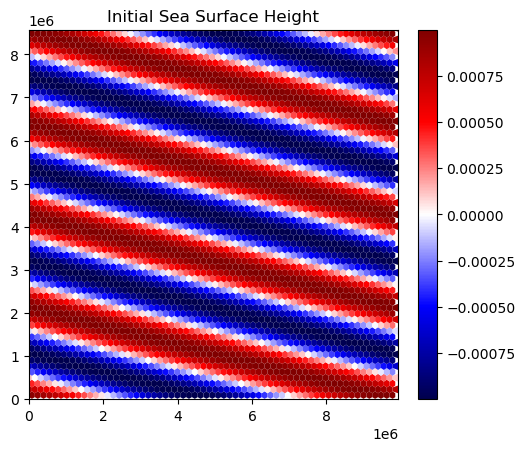

calculating exact solution


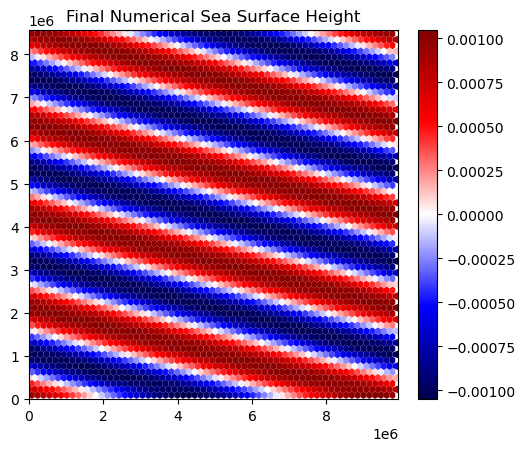

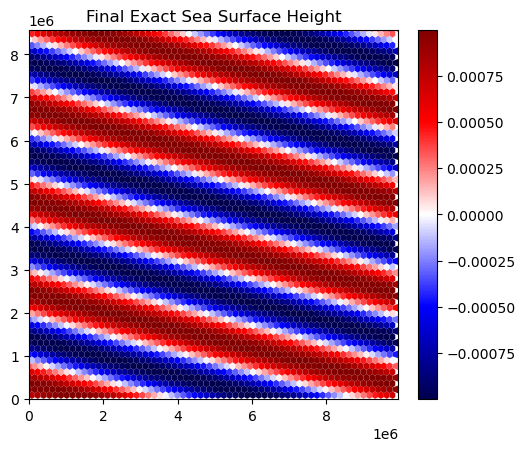

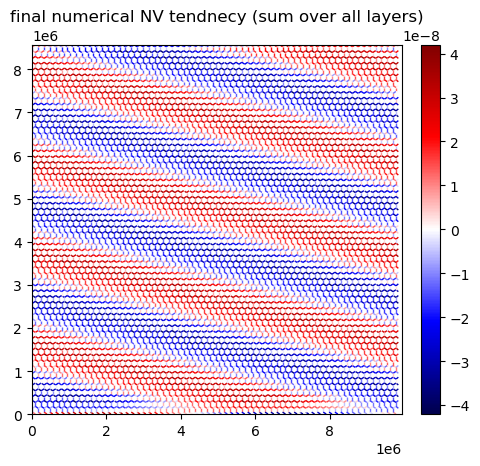

execution time: [0.09391660988330841, 0.08744188398122787, 0.07332240045070648, 0.07304573059082031, 0.07300256192684174, 0.07298234105110168, 0.07298874109983444, 0.07297728210687637, 0.07302755117416382, 0.0730191320180893]
L2 error from exact sol: 0.0019393449734777242


In [103]:
nCellsX = 64
wcgpu, errgpu, mpasOceanCuda, mpasMesh = gpuperftest(nCellsX, 10, 10, true, true, nvlevels=100)
println("execution time: $wcgpu")
println("L2 error from exact sol: $errgpu")

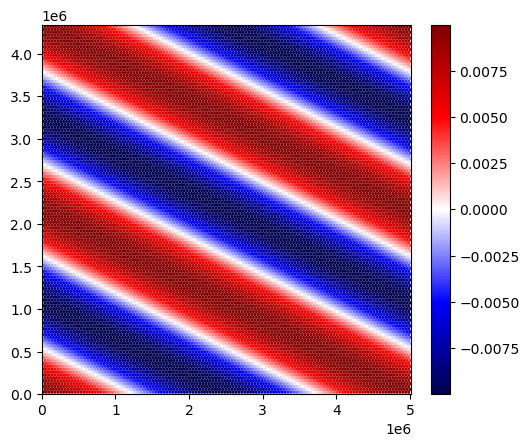

output file: /home/rrs/Desktop/MPAS/MPAS_Ocean_Julia/output/asrock/serialCPU_timing/coastal_kelvinwave/steps_10/resolution_128x128/nvlevels_100/2022-09-07T14:43:45.370.txt
calculating error


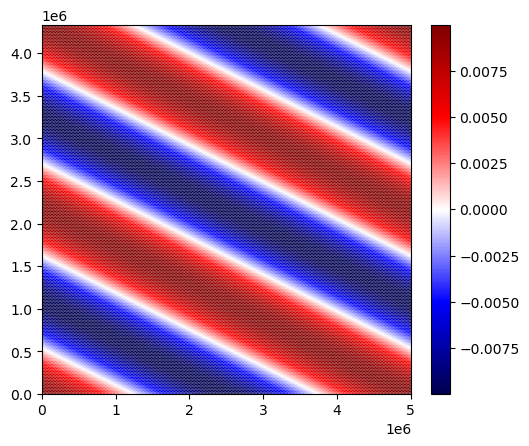

wallclock [12.579261383, 12.591102118]
error 0.05285548545241736
output file: /home/rrs/Desktop/MPAS/MPAS_Ocean_Julia/output/asrock/serialCPU_timing/coastal_kelvinwave/steps_10/resolution_256x256/nvlevels_100/2022-09-07T14:44:17.658.txt


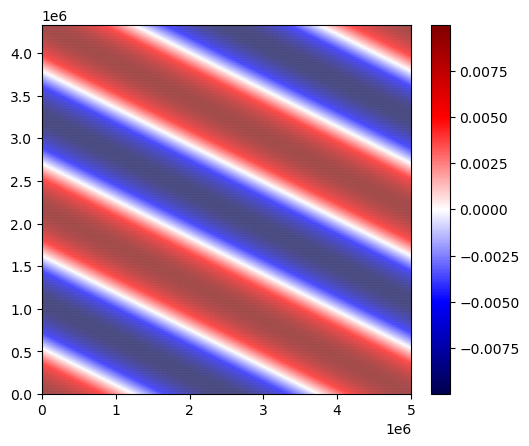

calculating error
wallclock [58.240570466, 57.753197177]
error 0.05372783193969387
output file: /home/rrs/Desktop/MPAS/MPAS_Ocean_Julia/output/asrock/serialCPU_timing/coastal_kelvinwave/steps_10/resolution_512x512/nvlevels_100/2022-09-07T14:46:20.753.txt
calculating error
wallclock [243.413986388, 246.80618255]
error 0.05394414641033389


In [4]:
for nCellsX in [128, 256, 512]
    wc, err = gpuperftest(nCellsX, 2, 10, true, true)
    println("wallclock $wc")
    println("error $err")
end

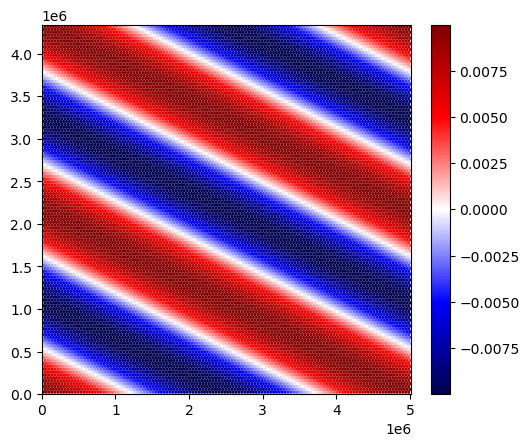

output file: /home/rrs/Desktop/MPAS/MPAS_Ocean_Julia/output/asrock/serialGPU_timing/coastal_kelvinwave/steps_10/resolution_128x128/nvlevels_100/2022-09-07T15:00:02.400.txt


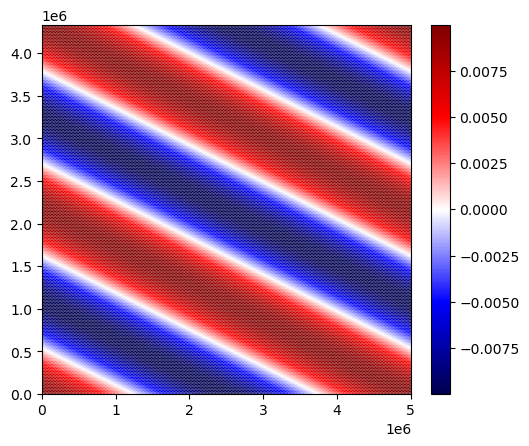

calculating error
wallclock [8.056696013, 6.4908e-5]
error 0.00036508535273453366
output file: /home/rrs/Desktop/MPAS/MPAS_Ocean_Julia/output/asrock/serialGPU_timing/coastal_kelvinwave/steps_10/resolution_256x256/nvlevels_100/2022-09-07T15:00:14.277.txt


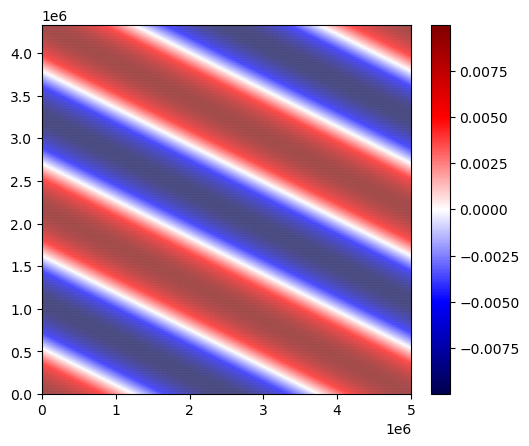

calculating error
wallclock [0.000102951, 6.0065e-5]
error 0.0001801138291574005
output file: /home/rrs/Desktop/MPAS/MPAS_Ocean_Julia/output/asrock/serialGPU_timing/coastal_kelvinwave/steps_10/resolution_512x512/nvlevels_100/2022-09-07T15:00:21.951.txt
calculating error
wallclock [0.000101572, 6.5236e-5]
error 8.931275374904333e-5


In [5]:
for nCellsX in [128, 256, 512]
    wc, err = gpucpuperftest(nCellsX, 2, 10, "GPU", true, true)
    println("wallclock $wc")
    println("error $err")
end

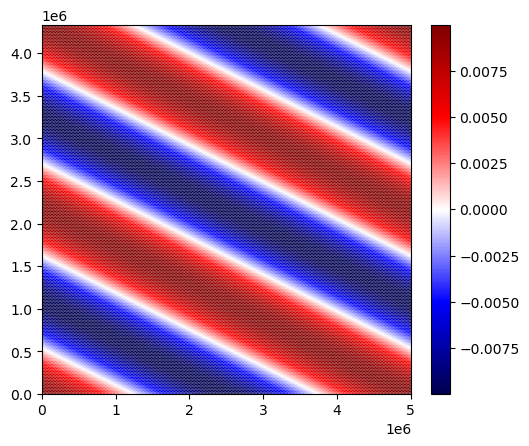

output file: /home/rrs/Desktop/MPAS/MPAS_Ocean_Julia/output/asrock/serialGPU_timing/coastal_kelvinwave/steps_10/resolution_256x256/nvlevels_100/2022-09-07T15:16:11.173.txt
calculating error


0

In [11]:
nCellsX = 256
wc, err, mpasOceanCuda = gpucpuperftest(nCellsX, 2, 10, "GPU", true, true)
mpasOcean = MPAS_Ocean(CODE_ROOT * "MPAS_O_Shallow_Water/MPAS_O_Shallow_Water_Mesh_Generation/CoastalKelvinWaveMesh/ConvergenceStudyMeshes",
        "culled_mesh_$nCellsX.nc", "mesh_$nCellsX.nc", periodicity="NonPeriodic_x", nvlevels=100)
0

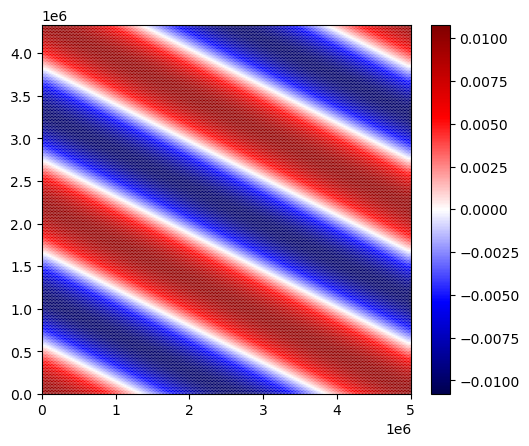

In [13]:
fig, ax, _ = heatMapMesh(mpasOcean, Array(mpasOceanCuda.sshCurrent))
display(fig)

the data copying step is actually 2 - 5 times slower than it is on the CPU! Memory is the bottleneck of the GPU